<a href="https://colab.research.google.com/github/Skyvaxs/Quantitative_Trading/blob/main/D%C3%A9monstration_technique_du_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Démonstration technique du projet : Deep Learning appliqué à la finance**


## **Présentation du projet**

### **Les marchés financiers**

Le cours d'une action est la clé de voûte des marchés financiers pour des investissements à court ou à long terme. La prédiction de l'évolution du prix d'une action serait donc un outil précieux pour les acteurs de marchés financiers. Il existe certains patterns (schémas graphiques spécifiques) permettant de prévoir le mouvement d'une action. 

<br>

**Exemples :**


<center><a href="https://zupimages.net/viewer.php?id=21/14/d8w5.png"><img src="https://zupimages.net/up/21/14/d8w5.png" alt="" /></a>
<center><i>Triangle descendant</i></center>
<br>

<a href="https://zupimages.net/viewer.php?id=21/14/gf9u.png"><img src="https://zupimages.net/up/21/14/gf9u.png" alt="" /></a>
<center><i>Triangle ascendant</i></center>
<br>

<a href="https://zupimages.net/viewer.php?id=21/14/kv52.png"><img src="https://zupimages.net/up/21/14/kv52.png" alt="" /></a>
<center><i>Triangle symétrique</i></center></center>

<br><br>

Notre projet est donc d'utiliser l'apprentissage profond (*Deep Learning*) afin de reconnaitre ces patterns et donc  d'anticiper le mouvement du cours boursier étudié. Dans notre cas, nous allons nous concentrer sur le NASDAQ qui est l'un des indices boursiers les plus volatiles.

### **Le Deep Learning**

<p align = "justify"> Ainsi, nous souhaitons donc analyser une quantité considérable de données et de graphes, et dans ces graphes reconnaître des patterns et pouvoir prédire l’évolution de ces graphes. La solution naturelle à ce problème est donc l’intelligence artificielle (IA) et plus particulièrement le Deep Learning (ou apprentissage profond en français). Le Deep Learning est une méthode de Machine Learning (apprentissage automatique) basé sur l’utilisation de réseaux de neurones.

Le réseau de neurones est une méthode de calcul non linéaire, en effet les réseaux de neurones représentent une matrice (en 2D ou en 3D) à qui l’on va envoyer nos données, ce calcul nous donnera une sortie que l’on comparera à notre valeur réelle puis grâce à ce calcul d’erreur, les coefficients de la matrice (et donc du réseau de neurones) sont actualisés pour correspondre le mieux à notre modèle. Ce processus est ainsi répété plusieurs fois, jusqu’à avoir une erreur correcte, et donc un bon modèle prédictif. </p>
<br>
<center>
<a href="https://zupimages.net/viewer.php?id=21/16/hls6.png"><img src="https://zupimages.net/up/21/16/hls6.png" alt="" /></a>
<br>
<i>Principe du Deep Learning</i></center>
<br>



## **Notre projet : prédiction du cours quotidien du Nasdaq**

### Importation des librairies et des données

In [ ]:
from __future__ import print_function

!pip install gast==0.2.2.

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.float_format = '{:.1f}'.format

Nasdaq_Composite = pd.read_csv("https://drive.google.com/uc?export=download&id=1Ha2NuXVWz8OnbGKC4CHrTGMX20Fh9Uni", sep=";")

#Nasdaq_Composite = Nasdaq_Composite.tail(5000)

Nasdaq_Composite.head()

,Date,Open,High,Low,Close,Adj Close,Volume,J-1,J-2,J-3,J-4,J-5,J-10,J-15,J-20,J-25,J-30
0,13/02/1980,165.0,165.0,165.0,165.0,165.0,0,164.6,164.5,165.2,163.8,163.0,161.3,158.5,156.0,151.6,148.2
1,14/02/1980,163.5,163.5,163.5,163.5,163.5,0,165.0,164.6,164.5,165.2,163.8,161.8,159.2,155.8,153.1,146.0
2,15/02/1980,162.6,162.6,162.6,162.6,162.6,0,163.5,165.0,164.6,164.5,165.2,162.3,159.7,156.1,153.9,148.0
3,19/02/1980,161.1,161.1,161.1,161.1,161.1,0,162.6,163.5,165.0,164.6,164.5,162.0,160.7,157.4,154.4,148.6
4,20/02/1980,162.1,162.1,162.1,162.1,162.1,0,161.1,162.6,163.5,165.0,164.6,162.2,160.3,156.9,155.0,150.7


### Définition des fonctions


In [ ]:
def normalisation(df):
    # copy the dataframe
    df_scaled = df.copy()
    del df_scaled['Date']
    
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    
    return df_scaled

In [ ]:
def preprocess_features(Nasdaq_Composite):
  """Prepares input features from Nasdaq Composite data set.

  Args:
    Nasdaq_Composite: A Pandas DataFrame expected to contain data
      from the Nasdaq Composite data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = Nasdaq_Composite[
    ["Open",
     "J-1",
     "J-2",
     "J-3",
     "J-4",
     "J-5",
     "J-10",
     "J-15",
     "J-20",
     "J-25",
     "J-30",
     ]]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(Nasdaq_Composite):
  """Prepares target features (i.e., labels) from Nasdaq Composite data set.

  Args:
    Nasdaq_Composite: A Pandas DataFrame expected to contain data
      from the Nasdaq Composite data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets["Close"] = (
    Nasdaq_Composite["Close"])
  return output_targets

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=False, num_epochs=None):
    """Trains a linear regression model of multiple features/neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified. (not in our case)
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

### Organisation des données


#### Normalisation des données

In [ ]:
Nasdaq_Composite =normalisation(Nasdaq_Composite)

#### Selection des données et répartition des données

Nous allons prendre notre dataset et le diviser en deux : une partie du dataset sera dédiée à l'entrainement de notre modèle (80%) , et le reste du dataset sera dédié à la validation de notre modèle (20% du dataset).

In [ ]:
training_examples = preprocess_features(Nasdaq_Composite.head(int(0.8*len(Nasdaq_Composite))))
training_examples.describe()

,Open,J-1,J-2,J-3,J-4,J-5,J-10,J-15,J-20,J-25,J-30
count,8214.0,8214.0,8214.0,8214.0,8214.0,8214.0,8214.0,8214.0,8214.0,8214.0,8214.0
mean,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
std,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
75%,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
max,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4


In [ ]:
training_targets = preprocess_targets(Nasdaq_Composite.head(int(0.8*len(Nasdaq_Composite))))
training_targets.describe()

,Close
count,8214.0
mean,0.1
std,0.1
min,0.0
25%,0.0
50%,0.1
75%,0.2
max,0.4


In [ ]:
validation_examples = preprocess_features(Nasdaq_Composite.tail(int(0.2*len(Nasdaq_Composite))))
validation_examples.describe()

,Open,J-1,J-2,J-3,J-4,J-5,J-10,J-15,J-20,J-25,J-30
count,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0
mean,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
std,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
min,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
25%,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
50%,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
75%,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
validation_targets = preprocess_targets(Nasdaq_Composite.tail(int(0.2*len(Nasdaq_Composite))))
validation_targets.describe()

,Close
count,2053.0
mean,0.5
std,0.2
min,0.2
25%,0.4
50%,0.4
75%,0.6
max,1.0


### **Régression linéaire**

#### Définition de notre modèle de régression linéaire

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    periods):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `Nasdaq_Composite` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `Nasdaq_Composite` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `Nasdaq_Composite` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `Nasdaq_Composite` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  
  my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["Close"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["Close"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["Close"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.6f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.6f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.6f" % validation_root_mean_squared_error)

  return (linear_regressor)


#### Entraînement du modèle

Training model...
RMSE (on training data):
  period 00 : 0.011589
  period 01 : 0.005846
  period 02 : 0.005512
  period 03 : 0.005425
  period 04 : 0.005292
  period 05 : 0.005192
  period 06 : 0.005165
  period 07 : 0.005198
  period 08 : 0.005262
  period 09 : 0.005330
  period 10 : 0.005386
  period 11 : 0.005421
  period 12 : 0.005429
  period 13 : 0.005410
  period 14 : 0.005365
  period 15 : 0.005302
  period 16 : 0.005230
  period 17 : 0.005163
  period 18 : 0.005116
  period 19 : 0.005106
Model training finished.
Final RMSE (on training data):   0.005106
Final RMSE (on validation data): 0.017884


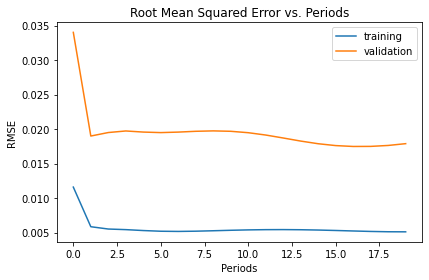

In [ ]:
linear_regressor = train_model(
    learning_rate=0.001,
    steps=5000,
    batch_size=64,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    periods=20)

#### Précision des valeurs prédites par le modèle type régression linéaire

In [ ]:
predict_testing_input_fn = lambda: my_input_fn(validation_examples, 
                                               validation_targets["Close"], 
                                               num_epochs=1, 
                                               shuffle=False)

validation_predictions_linear = linear_regressor.predict(input_fn=predict_testing_input_fn)
validation_predictions_linear = np.array([item['predictions'][0] for item in validation_predictions_linear])

In [ ]:
array_validation_targets=np.transpose(validation_targets.to_numpy())
difference_validation_linear = abs((validation_predictions_linear-array_validation_targets[0]))
difference_validation_linear_percentage = (difference_validation_linear*100)/array_validation_targets[0]
print("Precision validation: %0.2f %%" % np.mean(abs(difference_validation_linear_percentage)))

Precision validation: 2.79 %


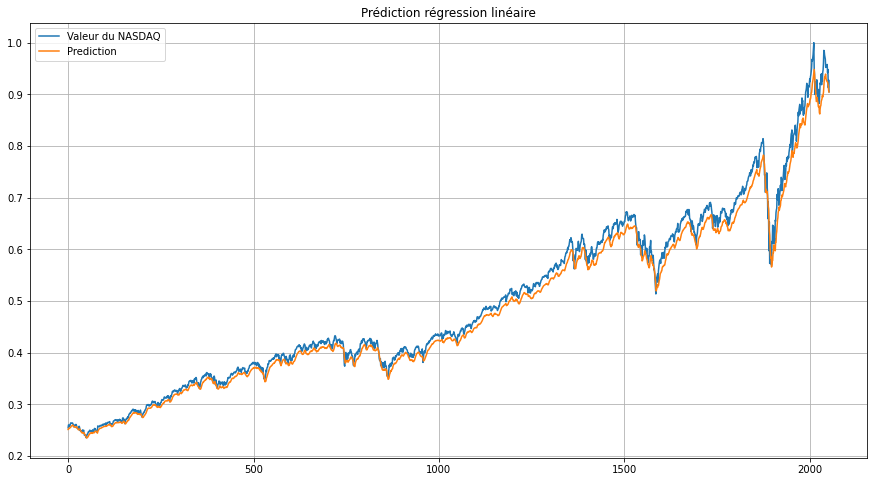

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(validation_targets.to_numpy())
plt.grid(True)
plt.plot(validation_predictions_linear)
plt.legend(['Valeur du NASDAQ','Prediction avec régression linéaire'])
plt.title('Prédiction avec régression linéaire')
plt.show()

### **Réseau de neurones (DNN)**

#### Définition de notre modèle de réseau de neurones

In [ ]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    periods):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `Nasdaq_Composite` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `Nasdaq_Composite` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `Nasdaq_Composite` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `Nasdaq_Composite` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.

  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Close"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Close"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Close"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d   RMSE_train : %0.6f RMSE_validation : %0.6f" % (period, training_root_mean_squared_error, validation_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15,8))
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.6f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.6f" % validation_root_mean_squared_error)

  return dnn_regressor

#### Entraînement du modèle

Training model...
RMSE (on training data):
  period 00   RMSE_test : 0.004842 RMSE_validation : 0.018209
  period 01   RMSE_test : 0.004406 RMSE_validation : 0.019563
  period 02   RMSE_test : 0.004223 RMSE_validation : 0.016217
  period 03   RMSE_test : 0.004006 RMSE_validation : 0.014639
  period 04   RMSE_test : 0.003918 RMSE_validation : 0.013641
  period 05   RMSE_test : 0.003851 RMSE_validation : 0.013005
  period 06   RMSE_test : 0.003793 RMSE_validation : 0.012571
  period 07   RMSE_test : 0.003739 RMSE_validation : 0.012213
  period 08   RMSE_test : 0.003687 RMSE_validation : 0.011890
  period 09   RMSE_test : 0.003637 RMSE_validation : 0.011664
  period 10   RMSE_test : 0.003589 RMSE_validation : 0.011442
  period 11   RMSE_test : 0.003542 RMSE_validation : 0.011238
  period 12   RMSE_test : 0.003498 RMSE_validation : 0.011047
  period 13   RMSE_test : 0.003455 RMSE_validation : 0.010871
  period 14   RMSE_test : 0.003413 RMSE_validation : 0.010711
  period 15   RMSE_test : 0

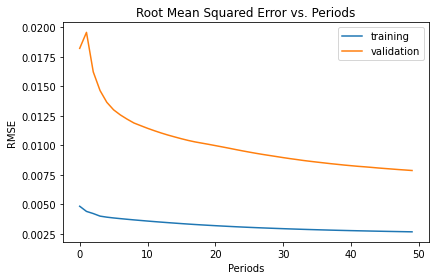

In [ ]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=100000,
    batch_size=64,
    hidden_units=[30,20,5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    periods=50)

#### Précision des valeurs prédites par le modèle type réseau de neurones

In [ ]:
predict_testing_input_fn = lambda: my_input_fn(validation_examples, 
                                               validation_targets["Close"], 
                                               num_epochs=1, 
                                               shuffle=False)

validation_predictions_neural = dnn_regressor.predict(input_fn=predict_testing_input_fn)
validation_predictions_neural = np.array([item['predictions'][0] for item in validation_predictions_neural])

In [ ]:
array_validation_targets=np.transpose(validation_targets.to_numpy())
difference_validation_neural = abs((validation_predictions_neural-array_validation_targets[0]))
difference_validation_neural_percentage = (difference_validation_neural*100)/array_validation_targets[0]
print("Precision validation: %0.2f %%" % np.mean(abs(difference_validation_neural_percentage)))

Precision validation: 0.94 %


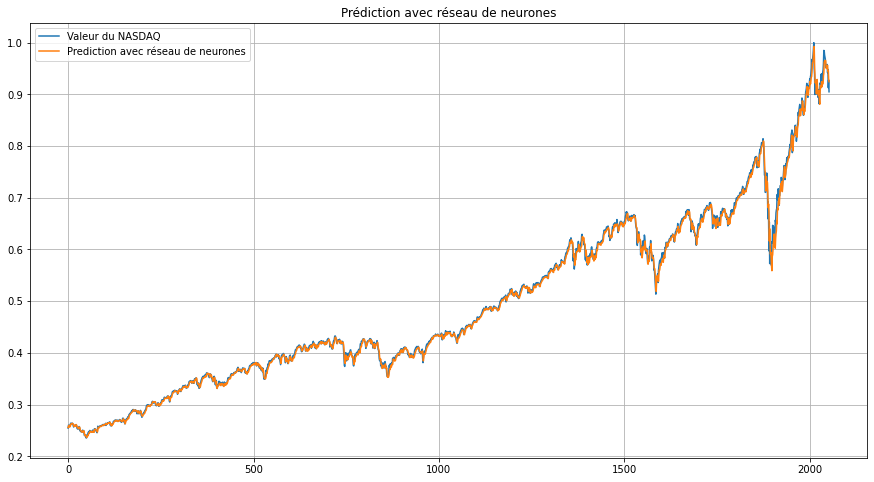

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(validation_targets.to_numpy())
plt.grid(True)
plt.plot(validation_predictions_neural)
plt.legend(['Valeur du NASDAQ','Prediction avec réseau de neurones'])
plt.title('Prédiction avec réseau de neurones')
plt.show()

### **Réseau de neurones (LSTM)**

#### Importation des données

In [ ]:
dataset_train = pd.read_csv("https://drive.google.com/uc?export=download&id=17Cl5ZOQt-QBrceIxfWNNczTm597v3Wyw", sep=";") #2001-2020 sans J-, high, low, adj close + VXN

dataset_train =normalisation(dataset_train)

close_serie = dataset_train["Close"]
close_values = close_serie.values
close_values=np.delete(close_values, -1)
close_values_bis=close_values
length_close=len(close_values_bis)
train_values = close_values_bis[0:int(0.8*length_close)]
test_values = close_values_bis[int(0.8*length_close):]

train_values=np.delete(train_values, -1)

In [ ]:
def create_window(dataset, start_index, end_index, history_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i])

    return np.array(data), np.array(labels)

#### Définition de notre modèle LSTM

In [ ]:
days_window = 15 #Nombre de jours pris en entrée
batch_size = 32

In [ ]:
train_features, train_labels = create_window(train_values, 0, None, days_window)
test_features, test_labels = create_window(test_values, 0, None, days_window)

import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(batch_size).repeat()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=(days_window, 1)), #Init 10 was 8
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

#### Entraînement du modèle

In [ ]:
history = model.fit(
    train_dataset,
    epochs=200,
    steps_per_epoch=int(len(train_features)/batch_size),
    validation_data=test_dataset,
    validation_steps=int(len(test_features)/batch_size)
)

Train on 123 steps, validate on 30 steps
Epoch 1/200
123/123 [==============================] - 3s 23ms/step - loss: 1.2928e-05 - val_loss: 5.8273e-04
Epoch 2/200
123/123 [==============================] - 2s 14ms/step - loss: 1.2684e-05 - val_loss: 6.3409e-04
Epoch 3/200
123/123 [==============================] - 2s 14ms/step - loss: 1.2731e-05 - val_loss: 6.8380e-04
Epoch 4/200
123/123 [==============================] - 2s 14ms/step - loss: 1.2642e-05 - val_loss: 7.0415e-04
Epoch 5/200
123/123 [==============================] - 2s 15ms/step - loss: 1.2813e-05 - val_loss: 7.0780e-04
Epoch 6/200
123/123 [==============================] - 2s 15ms/step - loss: 1.2833e-05 - val_loss: 7.0170e-04
Epoch 7/200
123/123 [==============================] - 2s 14ms/step - loss: 1.2705e-05 - val_loss: 6.6501e-04
Epoch 8/200
123/123 [==============================] - 2s 15ms/step - loss: 1.3003e-05 - val_loss: 6.3813e-04
Epoch 9/200
123/123 [==============================] - 2s 14ms/step - loss: 1.3

#### Précision des valeurs prédites par le modèle type LSTM

In [ ]:
validation_predictions_LSTM= model.predict(test_features)

difference_validation_LSTM = abs((np.transpose(validation_predictions_LSTM)-close_values[-len(validation_predictions_LSTM):]))
difference_validation_LSTM_percentage = (difference_validation_LSTM*100)/close_values[-len(validation_predictions_LSTM):]
print("Precision validation: %0.2f %%" % np.mean(abs(difference_validation_LSTM_percentage)))

Precision validation: 1.41 %


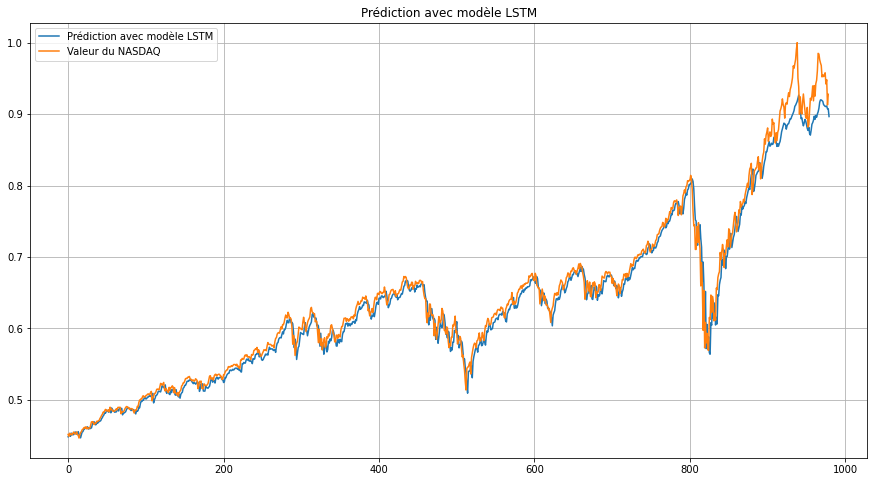

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(validation_predictions_LSTM)
plt.grid(True)
plt.plot(close_serie.values[-len(validation_predictions_LSTM):])
plt.legend(['Prédiction avec modèle LSTM','Valeur du NASDAQ'])
plt.title('Prédiction avec modèle LSTM')
plt.show()


#### Pourcentage tendance

In [ ]:
Open_values = validation_examples["Open"]
Open_values = Open_values.tolist()
Close_values = validation_targets["Close"]
Close_values = Close_values.tolist()

In [ ]:
min(Close_values)

0.23530493577033332

In [ ]:
import operator
Evolution= list(map(operator.sub, Close_values, Open_values))

In [ ]:
for k in range(0,len(Evolution)):
  if Evolution[k]>0:
    Evolution[k]=1
  elif Evolution[k]<0:
    Evolution[k]=-1
  else :
    Evolution[k]=0

In [ ]:
Evolution_prediction= list(map(operator.sub, validation_predictions_neural, Open_values))

In [ ]:
for k in range(0,len(Evolution_prediction)):
  if Evolution_prediction[k]>0:
    Evolution_prediction[k]=1
  elif Evolution_prediction[k]<0:
    Evolution_prediction[k]=-1
  else :
    Evolution_prediction[k]=0

In [ ]:
Evolution_difference = list(map(operator.sub, Evolution, Evolution_prediction))

In [ ]:
compteur=0
longueur_totale = len(Evolution_difference)
for k in range(0,len(Evolution_difference)):
  if Evolution_difference[k]==0:
    compteur=compteur+1;
precision_tendance_neural=100*compteur/len(Evolution_difference)
print("Precision prédiction tendance: %0.2f %%" % precision_tendance_neural)


Precision prédiction tendance: 49.98 %


### **Comparaison des différents modèles (Régression linéaires, DNN, LSTM)**

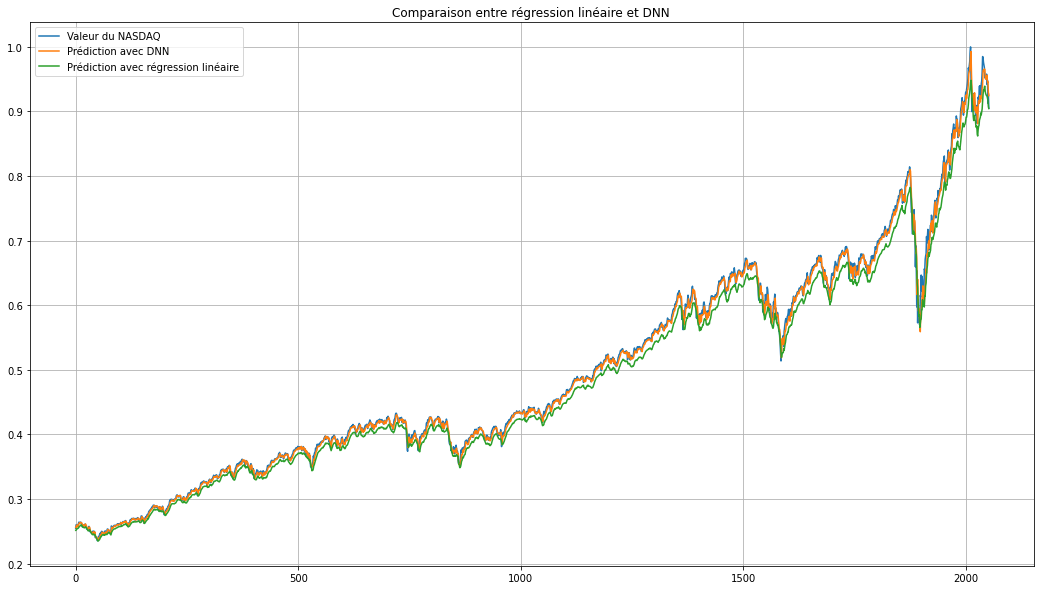

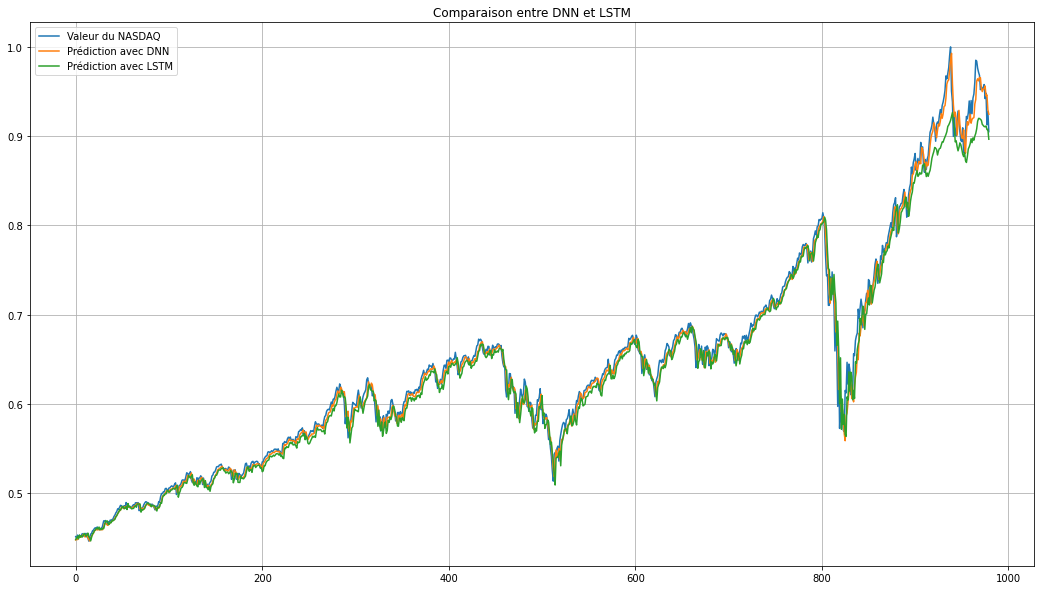

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(validation_targets.to_numpy())
plt.grid(True)
plt.plot(validation_predictions_neural)
plt.plot(validation_predictions_linear)
zeros_list = np.zeros(len(validation_predictions_neural)-len(validation_predictions_LSTM))
plt.legend(['Valeur du NASDAQ','Prédiction avec DNN','Prédiction avec régression linéaire'])
plt.title('Comparaison entre régression linéaire et DNN ')
plt.show()

plt.figure(figsize=(18,10))
plt.plot(validation_targets.to_numpy()[-len(validation_predictions_LSTM):])
plt.grid(True)
plt.plot(validation_predictions_neural[-len(validation_predictions_LSTM):])
plt.plot(validation_predictions_LSTM)
plt.legend(['Valeur du NASDAQ','Prédiction avec DNN','Prédiction avec LSTM'])
plt.title('Comparaison entre DNN et LSTM')
plt.show()

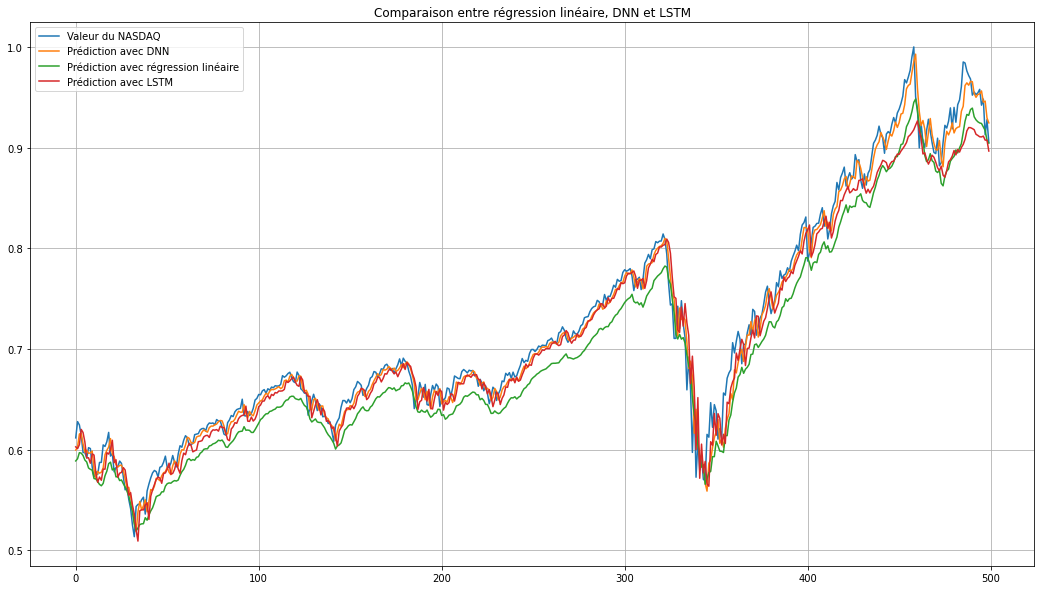

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(validation_targets.to_numpy()[-500:])
plt.grid(True)
plt.plot(validation_predictions_neural[-500:])
plt.plot(validation_predictions_linear[-500:])
plt.plot(validation_predictions_LSTM[-500:])
plt.legend(['Valeur du NASDAQ','Prédiction avec DNN','Prédiction avec régression linéaire','Prédiction avec LSTM'])
plt.title('Comparaison entre régression linéaire, DNN et LSTM')
plt.show()

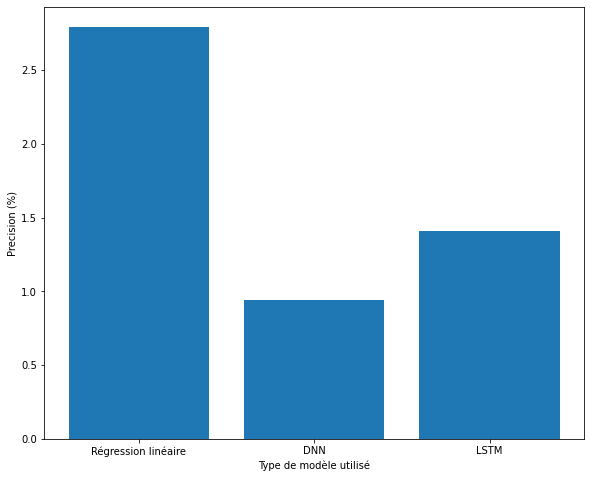

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7.5,6))
ax = fig.add_axes([0,0,1,1])
models = ['Régression linéaire', 'DNN', 'LSTM']
precision = [np.mean(abs(difference_validation_linear_percentage)),np.mean(abs(difference_validation_neural_percentage)),np.mean(abs(difference_validation_LSTM_percentage))]
ax.bar(models,precision)
ax.set_ylabel('Precision (%)')
ax.set_xlabel('Type de modèle utilisé')
plt.show()

## **Notre projet : prédiction du cours bihoraire du Nasdaq**

### Importation des librairies et des données

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn import metrics

keras = tf.keras
nasdaq_dataframe = pd.read_excel("https://drive.google.com/uc?export=download&id=1uS3DxVz9ipfzwRmDql6OvwoQHejgtgcK")

#Nasdaq_Composite = Nasdaq_Composite.tail(5000)

nasdaq_dataframe

,13030.54
0,13051.08
1,13002.62
2,12609.16
3,12609.16
4,12609.16
...,...
45277,2465.05
45278,2469.07
45279,2466.05
45280,2465.31


In [ ]:
def normalisation(df):
    # copy the dataframe
    df_scaled = df.copy()
    #del df_scaled['Date']
    
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    #df_scaled.loc[0]=["Date","Open","High","Low","Adj Close","Volume","J-1","J-2","J-3","J-4","J-5","J-10","J-15","J-20","J-25","J-30"]
    return df_scaled

In [ ]:
nasdaq_dataframe=normalisation(nasdaq_dataframe).to_numpy()
nasdaq_dataframe=list(reversed(nasdaq_dataframe))
nasdaq_dataframe=np.transpose(nasdaq_dataframe)[0]
nasdaq_dataframe

array([0.17450557, 0.17418832, 0.17424061, ..., 0.89090964, 0.91870985,
       0.92213383])

In [ ]:
split_time = 40000
x_train = nasdaq_dataframe[:split_time]
x_valid = nasdaq_dataframe[split_time:]

###Réseau de neurones RNN


####Définition des fonctions

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def ecart(vth,vsimu):
  m=len(vth)
  n=len(vsimu)
  e=[]
  if n!=m:
    return "Error: les deux listes ne sont pas de la même taille"
  else:
    for i in range(n):
      e.append(abs(vth[i]-vsimu[i])*100/vth[i])
    e_moy=np.mean(e)
    return e_moy


####Recherche du learning rate

In [ ]:
keras.backend.clear_session()
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set=window_dataset(x_valid,window_size)
train_set

<DatasetV1Adapter shapes: ((?, ?), (?,)), types: (tf.float64, tf.float64)>

In [ ]:
model = keras.models.Sequential([
  keras.layers.Dense(35, activation="relu", input_shape=[30]),
  keras.layers.Dense(15,activation="relu"),
  keras.layers.Dense(5,activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 20**(epoch / 10))
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])

Train on None steps
Epoch 1/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.8537e-04 - mean_squared_error: 3.7098e-04
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 8.4197e-05 - mean_squared_error: 1.6851e-04
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 2.2094e-05 - mean_squared_error: 4.4217e-05
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 7.1994e-06 - mean_squared_error: 1.4395e-05
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 5.2446e-06 - mean_squared_error: 1.0482e-05
Epoch 6/20
1250/1250 [==============================] - 9s 7ms/step - loss: 4.9858e-06 - mean_squared_error: 9.9743e-06
Epoch 7/20
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7886e-06 - mean_squared_error: 9.5735e-06
Epoch 8/20
1250/1250 [==============================] - 8s 7ms/step - loss: 4.7012e-06 - mean_squared_error: 9.4058e-06
Epoch 9/20
1250/12

(0.007523191898411367,
 3.940531934758218,
 -9.89306357281953e-05,
 0.0021568753726618276)

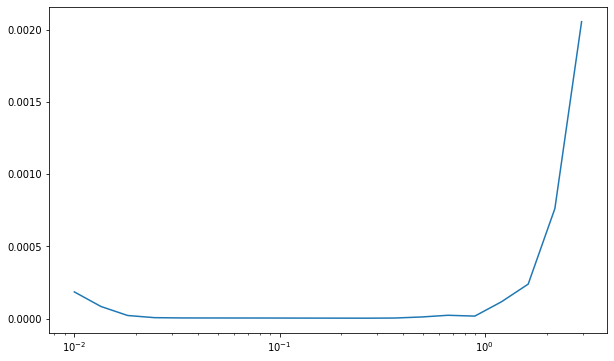

In [ ]:
plt.figure(figsize=(10,6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

####Entraînement du modèle

In [ ]:
model = keras.models.Sequential([
  keras.layers.Dense(35, activation="relu", input_shape=[30]),
  keras.layers.Dense(15,activation="relu"),
  keras.layers.Dense(5,activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-1)
optimizer = keras.optimizers.SGD(lr=1e-1, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[lr_schedule])

Epoch 1/500
1250/1250 [==============================] - 7s 6ms/step - loss: 2.6715e-04 - mse: 5.3431e-04 - val_loss: 1.4240e-04 - val_mse: 2.8480e-04
Epoch 2/500
1250/1250 [==============================] - 7s 5ms/step - loss: 6.0134e-06 - mse: 1.2027e-05 - val_loss: 2.1951e-04 - val_mse: 4.3902e-04
Epoch 3/500
1250/1250 [==============================] - 7s 5ms/step - loss: 3.6041e-06 - mse: 7.2081e-06 - val_loss: 6.3160e-05 - val_mse: 1.2632e-04
Epoch 4/500
1250/1250 [==============================] - 7s 5ms/step - loss: 3.4471e-06 - mse: 6.8942e-06 - val_loss: 9.2183e-05 - val_mse: 1.8437e-04
Epoch 5/500
1250/1250 [==============================] - 7s 5ms/step - loss: 2.9969e-06 - mse: 5.9938e-06 - val_loss: 7.8112e-05 - val_mse: 1.5622e-04
Epoch 6/500
1250/1250 [==============================] - 7s 6ms/step - loss: 2.5799e-06 - mse: 5.1599e-06 - val_loss: 5.1901e-05 - val_mse: 1.0380e-04
Epoch 7/500
1250/1250 [==============================] - 7s 5ms/step - loss: 2.4753e-06 - mse:

####Vérification de l'écart

In [ ]:
dense_forecast = model_forecast(
    model,
    nasdaq_dataframe[split_time - window_size:-1],
    window_size)[:, 0]

In [ ]:
ecart(dense_forecast,x_valid)

0.7012876969370457

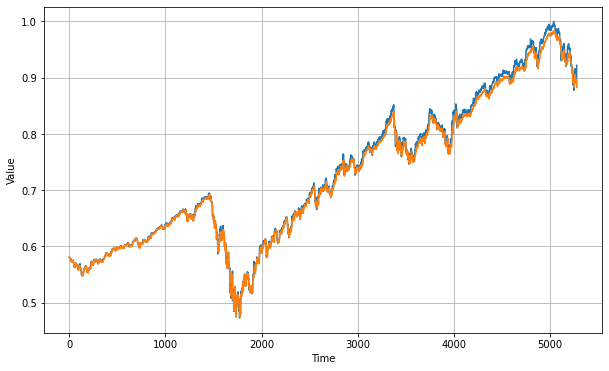

In [ ]:
time = np.arange(len(x_valid))
plt.figure(figsize=(10, 6))
plot_series(time, x_valid)
plot_series(time, dense_forecast)

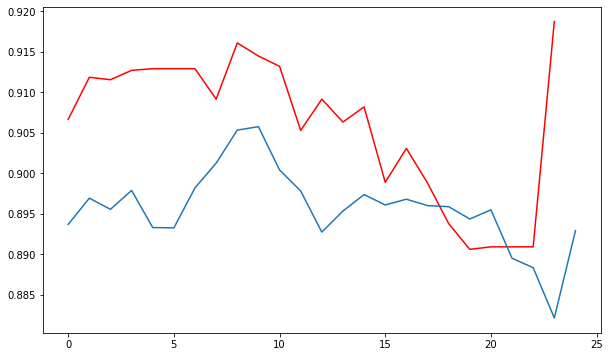

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x_valid[len(x_valid)-25:len(x_valid)-1],"-r")
plt.plot(dense_forecast[len(dense_forecast)-25:len(dense_forecast)])

###Réseau LSTM

####Définition des fonctions

In [ ]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()    

####Recherche du learning rate

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model_LSTM = keras.models.Sequential([
  keras.layers.LSTM(10, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  #keras.layers.LSTM(5, return_sequences=True, stateful=True,
                    #batch_input_shape=[1, None, 1]),
  keras.layers.Dense(1),
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2*20**(epoch/20) )
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=5e-2, momentum=0.9)
model_LSTM.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model_LSTM.fit(train_set, epochs=20,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/20
1333/1333 [==============================] - 11s 7ms/step - loss: 3.0589e-04 - mse: 6.1179e-04
Epoch 2/20
1333/1333 [==============================] - 9s 7ms/step - loss: 9.0847e-04 - mse: 0.0018
Epoch 3/20
1333/1333 [==============================] - 9s 7ms/step - loss: 8.1082e-04 - mse: 0.0016
Epoch 4/20
1333/1333 [==============================] - 9s 7ms/step - loss: 7.3074e-04 - mse: 0.0015
Epoch 5/20
1333/1333 [==============================] - 9s 7ms/step - loss: 6.6583e-04 - mse: 0.0013
Epoch 6/20
1333/1333 [==============================] - 9s 7ms/step - loss: 6.1416e-04 - mse: 0.0012
Epoch 7/20
1333/1333 [==============================] - 9s 7ms/step - loss: 5.7459e-04 - mse: 0.0011
Epoch 8/20
1333/1333 [==============================] - 9s 7ms/step - loss: 5.4718e-04 - mse: 0.0011
Epoch 9/20
1333/1333 [==============================] - 9s 7ms/step - loss: 5.3137e-04 - mse: 0.0011
Epoch 10/20
1333/1333 [==============================] - 9s 7ms/step - loss: 5.2282e-0

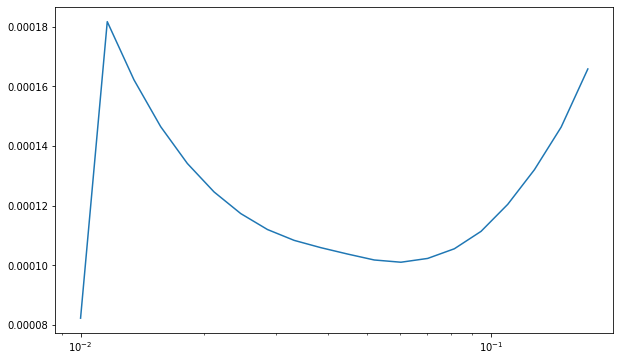

In [ ]:
plt.figure(figsize=(10,6))
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis()


####Entraînement du modèle

In [ ]:
keras.backend.clear_session()
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model_LSTM = keras.models.Sequential([
  keras.layers.LSTM(256, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),                                          
  keras.layers.Dense(1),
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 5e-2 )
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=5e-2, momentum=0.9)
model_LSTM.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model_LSTM.fit(train_set, epochs=300,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/300
1333/1333 [==============================] - 11s 7ms/step - loss: 4.3232e-04 - mse: 8.6465e-04
Epoch 2/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0016 - mse: 0.0032
Epoch 3/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0014 - mse: 0.0028
Epoch 4/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0013 - mse: 0.0027
Epoch 5/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0013 - mse: 0.0025
Epoch 6/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0012 - mse: 0.0024
Epoch 7/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0011 - mse: 0.0022
Epoch 8/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0011 - mse: 0.0021
Epoch 9/300
1333/1333 [==============================] - 10s 7ms/step - loss: 0.0010 - mse: 0.0020
Epoch 10/300
1333/1333 [==============================] - 10s 7ms/step - loss: 9.6103e-04 - mse: 0.00

####Evaluation de l'écart

In [ ]:
rnn_forecast = model_LSTM.predict(nasdaq_dataframe[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

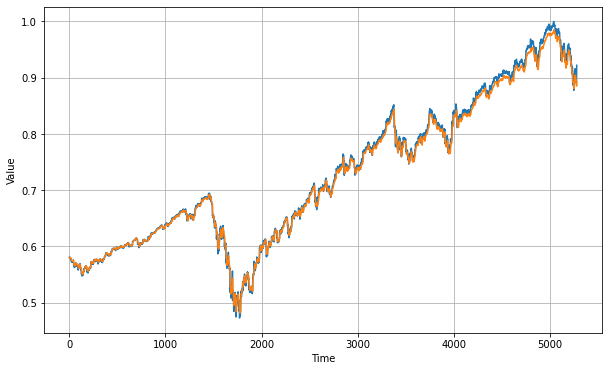

In [ ]:
time = np.arange(len(x_valid))
plt.figure(figsize=(10, 6))
plot_series(time, x_valid)
plot_series(time, rnn_forecast)

In [ ]:
ecart(x_valid,rnn_forecast)

0.6293772400863056

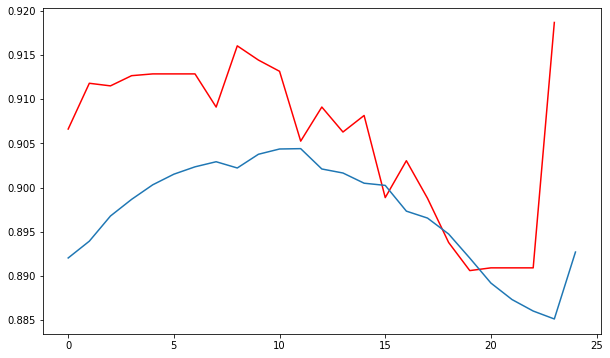

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x_valid[len(x_valid)-25:len(x_valid)-1],"-r")
plt.plot(rnn_forecast[len(rnn_forecast)-25:len(rnn_forecast)])